# COVID-19 Data Analyses using CDC Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Centers for Disease Control and Prevention's
[Provisional Death Counts for Coronavirus Disease](https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm).

This data source is less rich and appears to be less timely than either the Johns Hopkins or the New York
Times data.

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the CDC CSV file into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the plots!**](#Plots)


[bmc/covid19]: https://github.com/bmc/covid19/

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date, timezone
from enum import Enum
import csv
import os
import sys
import re
import math
from glob import glob
from dataclasses import dataclass
from lib.common import *
from lib.plot import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")
now = datetime.now(timezone.utc)
print(f"Last run on {now.strftime('%Y-%m-%d')} at {now.strftime('%H:%M:%S %Z')}")

Using Python 3.8.6
Using matplotlib 3.3.2
Using Pandas 1.1.4
Last run on 2020-12-09 at 23:09:06 UTC


In [2]:
CDC_DATA_PATH = 'data/cdc/Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
for p in glob(os.path.join(IMAGES_PATH, 'cdc*')):
    os.unlink(p)

## Preload the data we need

In [4]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


In [5]:
STARTING_DATE = datetime(year=2020, month=4, day=1)

In [6]:
%head $CDC_DATA_PATH

Data as of,Start week,End Week,Group,State,Indicator,COVID-19 Deaths,Total Deaths,Percent of Expected Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
12/09/2020,02/01/2020,02/01/2020,By week,United States,Week-ending,0,58790,0.99,3813,0,480,4293,
12/09/2020,02/08/2020,02/08/2020,By week,United States,Week-ending,1,59356,0.99,3808,0,521,4330,
12/09/2020,02/15/2020,02/15/2020,By week,United States,Week-ending,0,58770,1,3837,0,560,4397,
12/09/2020,02/22/2020,02/22/2020,By week,United States,Week-ending,4,58846,1.01,3707,1,566,4276,
12/09/2020,02/29/2020,02/29/2020,By week,United States,Week-ending,10,59262,1.03,3831,5,656,4492,
12/09/2020,03/07/2020,03/07/2020,By week,United States,Week-ending,36,59639,1.03,3974,18,634,4625,
12/09/2020,03/14/2020,03/14/2020,By week,United States,Week-ending,56,58617,1.03,3968,28,626,4621,
12/09/2020,03/21/2020,03/21/2020,By week,United States,Week-ending,573,59149,1.04,4543,250,558

In [7]:
# Load the data.

def load_data():
    df = pd.read_csv(CDC_DATA_PATH)
    date_fmt = '%m/%d/%Y'
    for col in ('Data as of', 'Start week', 'End Week'):
        df[col] = pd.to_datetime(df[col], format=date_fmt)

    df['month_day'] = df.apply(lambda r: r['Start week'].date().strftime("%m/%d"), axis=1)

    columns_to_rename = {
        'Data as of':      'data_as_of',
        'Start week':      'start_week',
        'End Week':        'end_week',
        'Group':           'group',
        'State':           'state',
        'Indicator':       'indicator',
        'COVID-19 Deaths': 'week_deaths',
        'Total Deaths':    'total_deaths',
    }

    df2 = df.rename(columns=columns_to_rename)
    df2['week_deaths'] = df2['week_deaths'].fillna(0)
    df2['total_deaths'] = df2['total_deaths'].fillna(0)
    df3 = df2.loc[df2.start_week >= STARTING_DATE]
    desired_columns = list(columns_to_rename.values()) + ['month_day']
    return df3[desired_columns]

In [8]:
df = load_data()
df

,data_as_of,start_week,end_week,group,state,indicator,week_deaths,total_deaths,month_day
9,2020-12-09,2020-04-04,2020-04-04,By week,United States,Week-ending,10044.0,72227.0,04/04
10,2020-12-09,2020-04-11,2020-04-11,By week,United States,Week-ending,16205.0,78985.0,04/11
11,2020-12-09,2020-04-18,2020-04-18,By week,United States,Week-ending,17093.0,76666.0,04/18
12,2020-12-09,2020-04-25,2020-04-25,By week,United States,Week-ending,15460.0,73794.0,04/25
13,2020-12-09,2020-05-02,2020-05-02,By week,United States,Week-ending,13164.0,69211.0,05/02
...,...,...,...,...,...,...,...,...,...
2425,2020-12-09,2020-11-07,2020-11-07,By week,Puerto Rico,Week-ending,45.0,286.0,11/07
2426,2020-12-09,2020-11-14,2020-11-14,By week,Puerto Rico,Week-ending,55.0,163.0,11/14
2427,2020-12-09,2020-11-21,2020-11-21,By week,Puerto Rico,Week-ending,59.0,83.0,11/21
2428,2020-12-09,2020-11-28,2020-11-28,By week,Puerto Rico,Week-ending,66.0,66.0,11/28


In [9]:
def get_death_counts(df, state='United States', trim_final_week=True):
    """
    Extract weekly death counts for a particular state or
    for the United States as a whole.

    Returns a new DataFrame with only data for the specified state,
    with the 'start_week', 'month_day', 'state', and 'week_deaths'
    columns, as well as a 'cumulative_deaths' column that captures
    cumulative deaths as of a given week.
    
    Parameters:
    
    df              - Pandas DataFrame containing the CDC data,
                      as loaded by load_data()
    state           - The state for which data is to be returned.
    trim_final_week - True to trim the final week; False otherwise.

    NOTE: The final week of the CDC data is automatically trimmed
    (unless trim_final_week is set to False), because experience
    shows that it generally represents partial data, which skews the
    graphs.
    """
    df2 = df.loc[df.state == state].sort_values('month_day', inplace=False)
    if trim_final_week:
        df2.drop(df2.tail(1).index, inplace=True)

    df2['cumulative_deaths'] = df2.week_deaths.cumsum()
    return df2[['start_week', 'month_day', 'state', 'week_deaths',
                'cumulative_deaths']]

In [10]:
class PlotType(Enum):
    WEEKLY_DEATHS = 0
    CUMULATIVE_DEATHS = 1

    @classmethod
    def all(cls):
        return set([v for v in PlotType])


PLOT_TYPE_COLORS = {
    PlotType.WEEKLY_DEATHS: 'orange',
    PlotType.CUMULATIVE_DEATHS: 'red'
}

PLOT_TYPE_COLUMNS = {
    PlotType.WEEKLY_DEATHS: 'week_deaths',
    PlotType.CUMULATIVE_DEATHS: 'cumulative_deaths'  
}

PLOT_TYPE_LABELS = {
    PlotType.WEEKLY_DEATHS: 'weekly deaths',
    PlotType.CUMULATIVE_DEATHS: 'cumulative deaths'   
}

def plot_deaths_for_one(df, state, plot_types={PlotType.CUMULATIVE_DEATHS},
                        image_file=None, figsize=(20, 12), legend_loc='upper center',
                        marker=False, trim_final_week=True):
    """
    Extract weekly death counts for a particular state or
    for the United States as a whole, via a call to get_death_counts(),
    and plot the data.
    
    Parameters:
    
    df              - Pandas DataFrame containing the CDC data,
                      as loaded by load_data()
    state           - The state for which data is to be plotted.
    plot_types      - Whether to plot cumulative deaths, weekly deaths,
                      or both.
    image_file      - Optional name of file to which to save the plot.
    figsize         - The desired size of the plot.
    legend_loc      - Desired location of the legend. The legend is
                      only displayed if more than one plot type is
                      set.
    marker          - True to display a marker for each data point.
                      False to suppress the marker.
    trim_final_week - True to trim the final week; False otherwise.

    NOTE: The final week of the CDC data is automatically trimmed
    (unless trim_final_week is set to False), because experience
    shows that it generally represents partial data, which skews the
    graphs.
    """
    df2 = get_death_counts(df, state, trim_final_week)
    fig, ax = plt.subplots(figsize=figsize)
    legend_labels = []
    for m in PlotType:
        if m in plot_types:
            column = PLOT_TYPE_COLUMNS[m]
            legend_labels.append(PLOT_TYPE_LABELS[m])
            # No grouping is necessary here, because there's
            # only one row per week in the CDC data. Just select
            # the columns we want to plot.
            df2.plot(x='month_day', y=column,
                     ax=ax, figsize=figsize, 
                     color=PLOT_TYPE_COLORS[m],
                     marker=('s' if marker else None))

    date_fmt = '%b %d'
    start_date = df2.start_week.min().strftime(date_fmt)
    end_date = df2.start_week.max().strftime(date_fmt)

    text_lines = [f"{state} deaths from {start_date} to {end_date}"]
    if PlotType.CUMULATIVE_DEATHS in plot_types:
        total = int(round(df2.cumulative_deaths.max()))
        text_lines.append(f'\nTotal deaths: {total:,}')

    textbox(ax, 0.01, 0.98, '\n'.join(text_lines))

    if len(plot_types) > 1:
        ax.legend(legend_labels, loc=legend_loc)

    ax.set_ylabel(f"{state} deaths")
    ax.set_xlabel("Week\n\n(Source: CDC)")
    
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))

    return fig, ax

## Plots

### US deaths

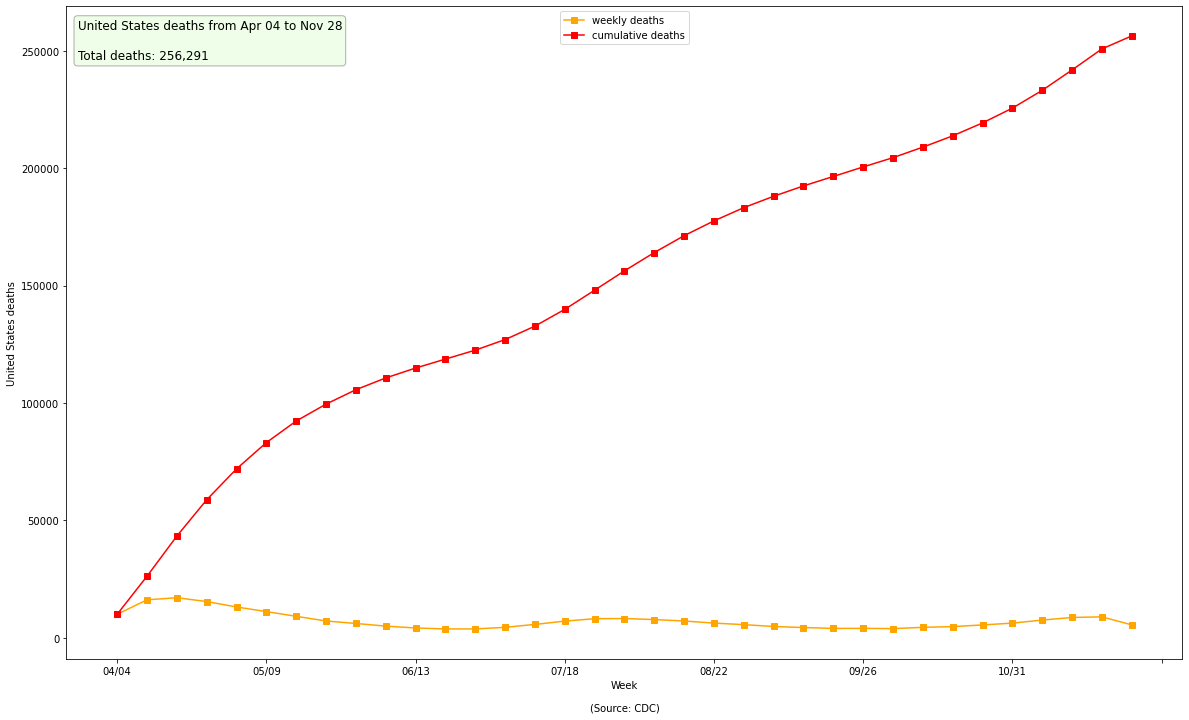

In [11]:
fig, ax = plot_deaths_for_one(df, 'United States', plot_types=PlotType.all(), marker=True,
                              image_file='cdc-us-deaths.png')

### Pennsylvania (my home state)

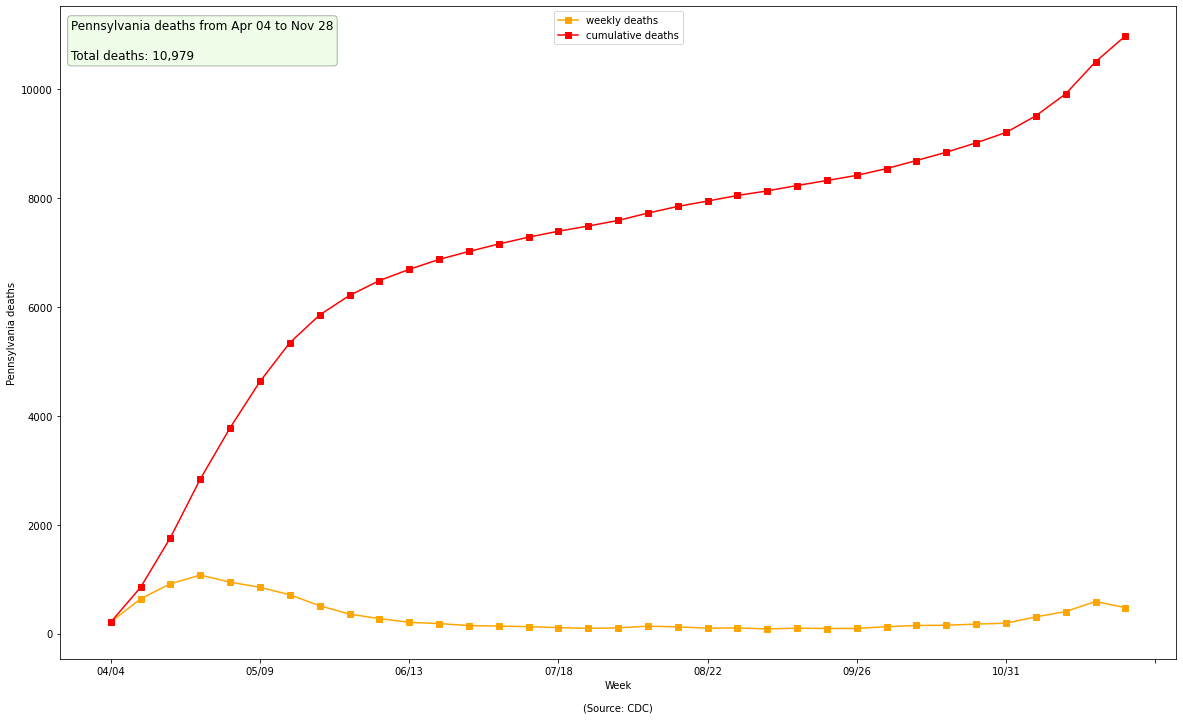

In [12]:
fig, ax = plot_deaths_for_one(df, 'Pennsylvania', plot_types=PlotType.all(), marker=True,
                              image_file='cdc-pa-deaths.png')

### California

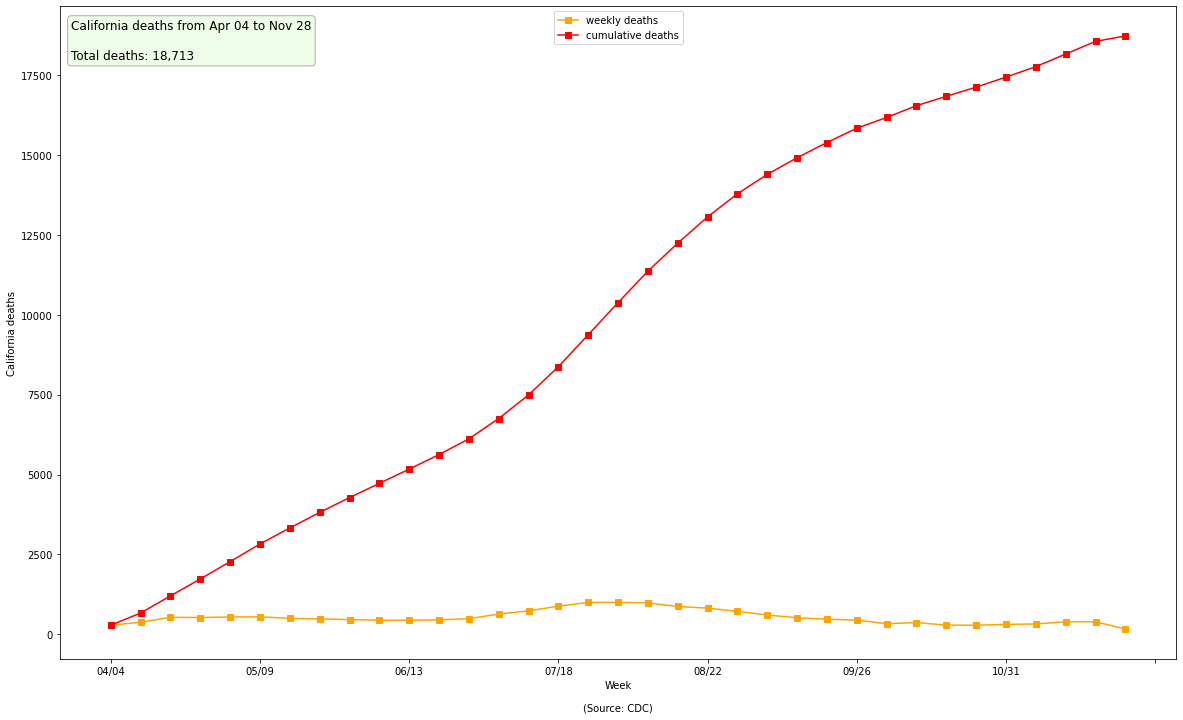

In [13]:
fig, ax = plot_deaths_for_one(df, 'California', plot_types=PlotType.all(), marker=True,
                              image_file='cdc-ca-deaths.png')

### Comparing deaths in groups of states

In [14]:
def plot_deaths_for_many(df, states, plot_type, image_file=None, 
                         per_n=1, populations=None,
                         figsize=(20, 12), legend_loc='best',
                         marker=False, trim_final_week=True):
    """
    Extract weekly death counts for multiple states (or the U.S.)
    via calls to get_death_counts(), and plot the data.
    
    Parameters:
    
    df              - Pandas DataFrame containing the CDC data,
                      as loaded by load_data()
    states          - The state for which data is to be plotted.
    plot_types      - Whether to plot cumulative deaths or weekly deaths.
    image_file_name - Optional name of file to which to save the plot.
    per_n           - If set to 1, plot the data as is. Otherwise, do a per-capita
                      plot (i.e., number of X per n people). If per_n is not 1,
                      then population must be defined.
    populations     - The dictionary of populations per state. Only necessary
                      if per_n is greater than 1.
    figsize         - The desired size of the plot.
    legend_loc      - Desired location of the legend. The legend is
                      only displayed if more than one plot type is
                      set.
    marker          - True to display a marker for each data point.
                      False to suppress the marker.
    trim_final_week - True to trim the final week; False otherwise.

    NOTE: The final week of the CDC data is automatically trimmed
    (unless trim_final_week is set to False), because experience
    shows that it generally represents partial data, which skews the
    graphs.
    """
   
    df2 = pd.concat([get_death_counts(df, s) for s in states])
    column = PLOT_TYPE_COLUMNS[plot_type]

    if per_n > 1:
        df2[column] = df2.apply(
            lambda row: get_per_capita_float(row[column], populations[row.state], per_n=per_n),
            axis=1
        )

    # Since there's only one row for each date (per state), the group by
    # isn't strictly necessary, but we have to call unstack(), and that's
    # not going to work without a group by. sum() is effectively a no-op
    # here.
    to_plot = (
        df2[['month_day', 'state', column]]
            .groupby(['month_day', 'state'])
            .sum()
            .unstack()
    )

    fig, ax = plt.subplots(figsize=figsize)
    to_plot.plot(ax=ax, kind='line', legend=True, marker=('s' if marker else None))

    ax.set_xlabel('Week\n\n(Source: CDC)')
    label = PLOT_TYPE_LABELS[plot_type]
    y_label = f"{label}"
    if per_n > 1:
        y_label = f"{y_label} per {per_n:,}"
    ax.set_ylabel(y_label)

    # If we're plotting cumulative deaths, display an info
    # box showing the total deaths for each state. (It doesn't
    # make sense to do this with weekly deaths.)
    if plot_type == PlotType.CUMULATIVE_DEATHS:
        heading = 'Total deaths' if per_n == 1 else f'Total deaths per {per_n:,}'
        text_lines = [f'{heading}\n']
        for state in sorted(states):
            total = int(round(df2.loc[df2.state == state][column].max()))
            text_lines.append(f"{state}: {total:,}")
        textbox(ax, 0.01, 0.99, '\n'.join(text_lines))
        if legend_loc == 'best':
            legend_loc = 'upper center'

    fix_pandas_multiplot_legend(ax, legend_loc)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))

    return (ax, fig)


### Northeast states

Data from some of the states that were hardest hit early on.

In [15]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

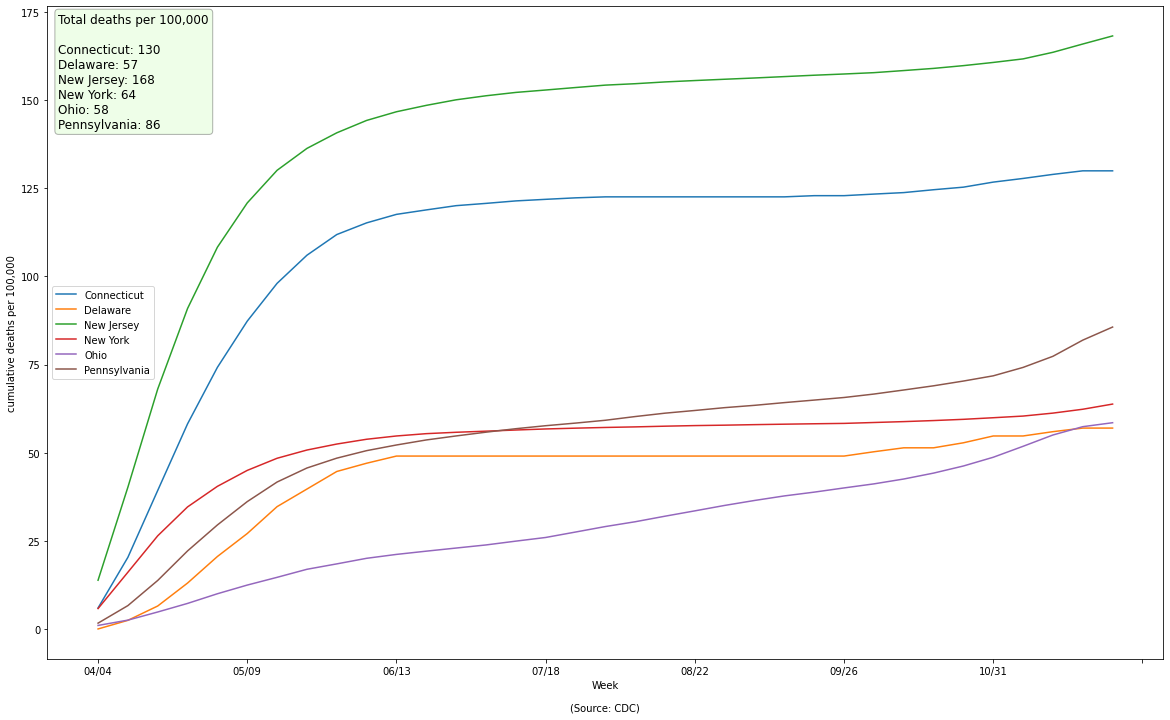

In [16]:
plot_deaths_for_many(df, ne_states, PlotType.CUMULATIVE_DEATHS, per_n=100_000, populations=populations,
                     image_file='cdc-ne-states-cum-deaths.png', legend_loc='center left');

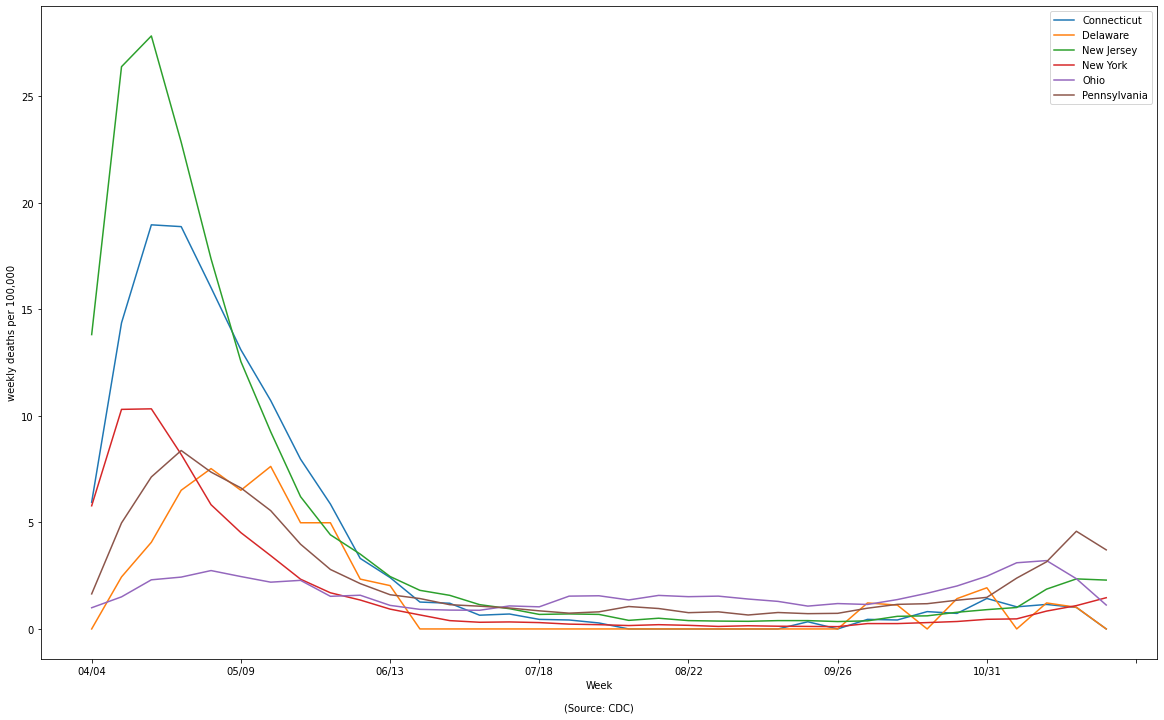

In [17]:
plot_deaths_for_many(df, ne_states, PlotType.WEEKLY_DEATHS, per_n=100_000, populations=populations,
                     image_file='cdc-ne-states-weeklyl-deaths.png');

#### Some of the bigger-hit states after the hurried reopenings

- California
- Arizona
- Texas
- Florida
- Oklahoma
- South Carolina

In [18]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

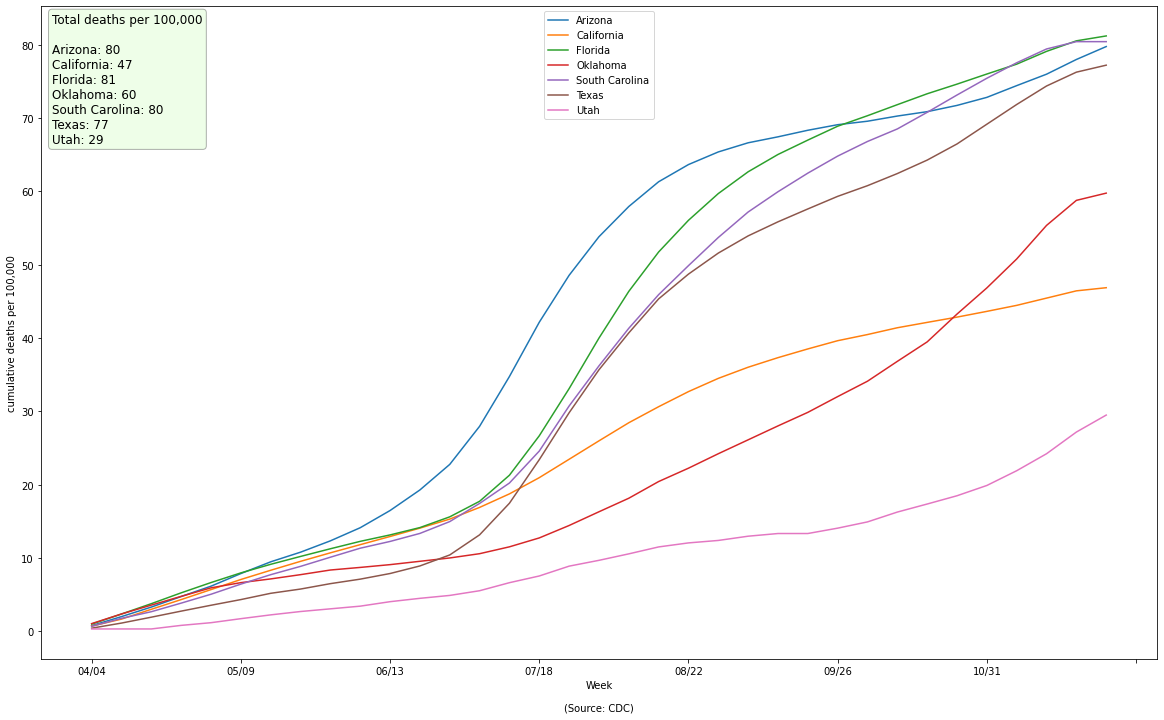

In [19]:
plot_deaths_for_many(df, s_sw_states, PlotType.CUMULATIVE_DEATHS, per_n=100_000, populations=populations,
                     image_file='cdc-s-sw-states-cum-deaths.png');

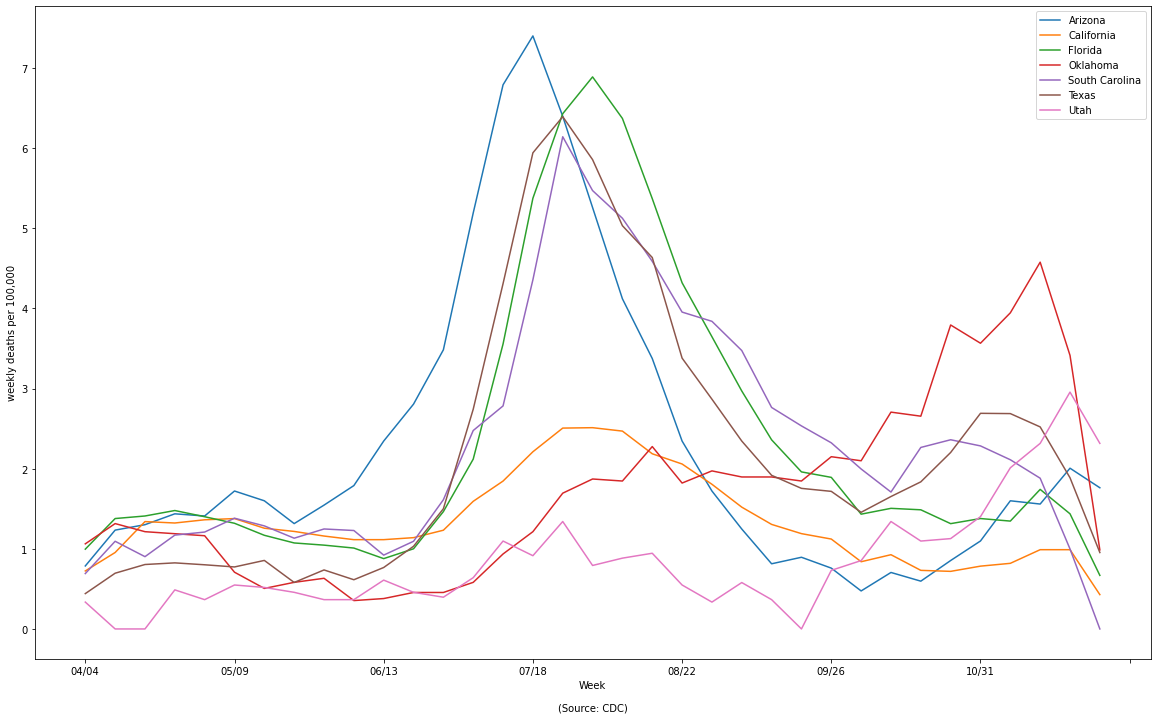

In [20]:
plot_deaths_for_many(df, s_sw_states, PlotType.WEEKLY_DEATHS, per_n=100_000, populations=populations,
                     image_file='cdc-s-sw-states-cum-deaths.png');